# Prediction of energy market prices (part 2)

You are given meteorological and market data for part of 2025. [Meteorological data file](https://github.com/jkved/enerheads-quant-challenge/blob/main/data/weather_location_Vilnius.csv)(s) contains day-ahead and intraday forecasts for meteorological variables for a single location. The data description is available on [OpenMeteo](https://open-meteo.com/en/docs) docs and the timezone here is in UTC. This will contain some of your predictors values. Day ahead value (with suffix `previous_day1`) is known 24 hours before delivery time, intraday (no suffix column) is around 1 hour before or at delivery time. Market data (predictors and target values) is given in file [market data file](https://github.com/jkved/enerheads-quant-challenge/blob/main/data/market_data.csv), the data is also publicly available on [Baltic transparency dashboard](https://baltic.transparency-dashboard.eu/). Here index is in UTC timezone and two columns here are considered our target variables:
- `10YLT-1001A0008Q_DA_eurmwh` - this is Nord Pool day-ahead auction cleared prices (EUR/MWh). It is resolved day before delivery day (day-ahead), i.e. today at 10:00 UTC we find out prices for tommorrow CET day (22:00 UTC today -> 22:00 UTC tommorrow). Only weather data with `previous_day1` suffix is available at inference time
- `LT_up_sa_cbmp` or `LT_down_sa_cbmp` - this is mFRR activation prices. Generally only up or down activations take place at the same time so price is duplicated in these columns. It is resolved at delivery time (intraday). All weather data and Nord Pool prices are available at inference time but all other market data is visible with a 30 minute lag, i.e. for an mFRR activation price @ 11:00, all other market data is visible only up to (not including) 10:30.

Complete the following tasks:

1. Create Nord Pool prices forecasting model in day-ahead setting.
2. Create mFRR prices forecasting model in intraday setting
3. Implement certain evaluation metrics for prices:
   - you wish to accurately guess times when smallest and largest prices of the day take shape.
   - you wish to know how many instances there are with spreads between smallest and largest prices being bigger than X (say, 200 EUR/MWh).
4. Choose a collection of 2-3 plots to visualize the performance of both models.


# Importing Data 

In [1]:
from functools import reduce
import glob
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import warnings

from utils import get_time_of_day, get_season

In [2]:
warnings.filterwarnings("ignore")

In [3]:
market_df = pd.read_csv("data/market_data.csv", index_col=0)
market_df.index = pd.to_datetime(market_df.index, utc=True)
print(market_df.shape)
market_df.head()

(11424, 100)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [4]:
files = glob.glob("data/weather_location_*.csv")
dfs = []

for file in files:
    city = os.path.splitext(os.path.basename(file))[0].replace("weather_location_", "")
    df = pd.read_csv(file, index_col=0)
    df = df.rename(columns={col: f"{col}_{city}" for col in df.columns})
    
    dfs.append(df)

weather_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
print(weather_df.shape)
weather_df.head()

(2856, 140)


,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.333627,13.684512,125.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0
2025-03-01 01:00:00+00:00,12.280973,14.737166,123.0,99.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0
2025-03-01 02:00:00+00:00,13.333627,12.631857,118.0,101.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.8735,1.8235,89.0,90.0
2025-03-01 03:00:00+00:00,11.228318,9.473893,130.0,102.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.7735,1.8235,89.0,89.0
2025-03-01 04:00:00+00:00,9.123008,7.368583,152.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9235,1.7235,90.0,90.0


In [5]:
percent_missing = 0.5
market_df_filtered = market_df.loc[:, market_df.isnull().mean() < percent_missing]
print(market_df_filtered.shape)
market_df_filtered.head()

(11424, 68)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


# mFRR prices forecasting model in intraday setting

I will choose my target column `LT_up_sa_cbmp`. Let's fill in the NaNs with the average value of the row above and below the unknown value.

In [6]:
market_df_filtered["LT_up_sa_cbmp"].isna().sum()

424

In [7]:
market_df_filtered.loc[:, "LT_up_sa_cbmp"] = market_df_filtered["LT_up_sa_cbmp"].interpolate(
    method="linear", limit_direction="both"
)

In [8]:
market_df_filtered["LT_up_sa_cbmp"].isna().sum()

0

Let's create a 30 minute lag in the market dataframe. 

In [9]:
targets = ["10YLT-1001A0008Q_DA_eurmwh", "LT_up_sa_cbmp", "LT_down_sa_cbmp"]
features =  [col for col in market_df_filtered.columns if col not in targets]


In [10]:
lagged_market = market_df_filtered[features].shift(2)
lagged_market.head()

,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LV_up_sa_cbmp,LV_down_sa_cbmp,LT_up_da_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.0,400.0,927.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,927.02
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.0,400.0,400.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,932.81
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.5,400.0,927.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,119.23


In [11]:
weather_upsampled = weather_df.loc[weather_df.index.repeat(4)].copy()
weather_upsampled.index = market_df_filtered.index
merged_df = pd.concat([
    lagged_market,
    market_df_filtered[["10YLT-1001A0008Q_DA_eurmwh"]], 
    weather_upsampled,
    market_df_filtered[["LT_up_sa_cbmp"]] 
], axis=1)

print(merged_df.shape)
merged_df.head(8)

(11424, 207)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27
2025-03-01 01:15:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27
2025-03-01 01:30:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27
2025-03-01 01:45:00+00:00,3.061,0.000,3.315,0.0,0.00,2.38,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27


In [12]:
df = merged_df.copy()

df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["time_of_day"] = df["hour"].apply(get_time_of_day)
df["season"] = df["month"].apply(get_season)
df["time_of_day"] = df["time_of_day"].astype("category")
df["season"] = df["season"].astype("category")

print(df.shape)
df.head()

(11424, 212)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp,hour,dayofweek,month,time_of_day,season
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.0,400.0,927.0,-273.0,20.0,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.0,400.0,400.0,-273.0,20.0,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.5,400.0,927.0,-273.0,20.0,...,1.9735,1.7735,89.0,91.0,27.27,1,5,3,night,spring


In [13]:
features =  [col for col in df.columns if col not in targets]
df = df.sort_index()

split_idx = int(len(df) * 0.8)
X_train = df[features].iloc[:split_idx]
y_train = df[targets[1]].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df[targets[1]].iloc[split_idx:]

In [14]:
model_xgb = XGBRegressor(
    random_state=9,
    enable_categorical=True,
    tree_method="hist",
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [400, 450, 500],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.025, 0.05],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.4, 0.5, 0.6],
}


tscv = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,  
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best MAE CV:", -grid_search_xgb.best_score_)
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("Test MAE:", round(mae_test_xgb, 4))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1}
Best MAE CV: 91.8912526324783
Test MAE: 115.8296


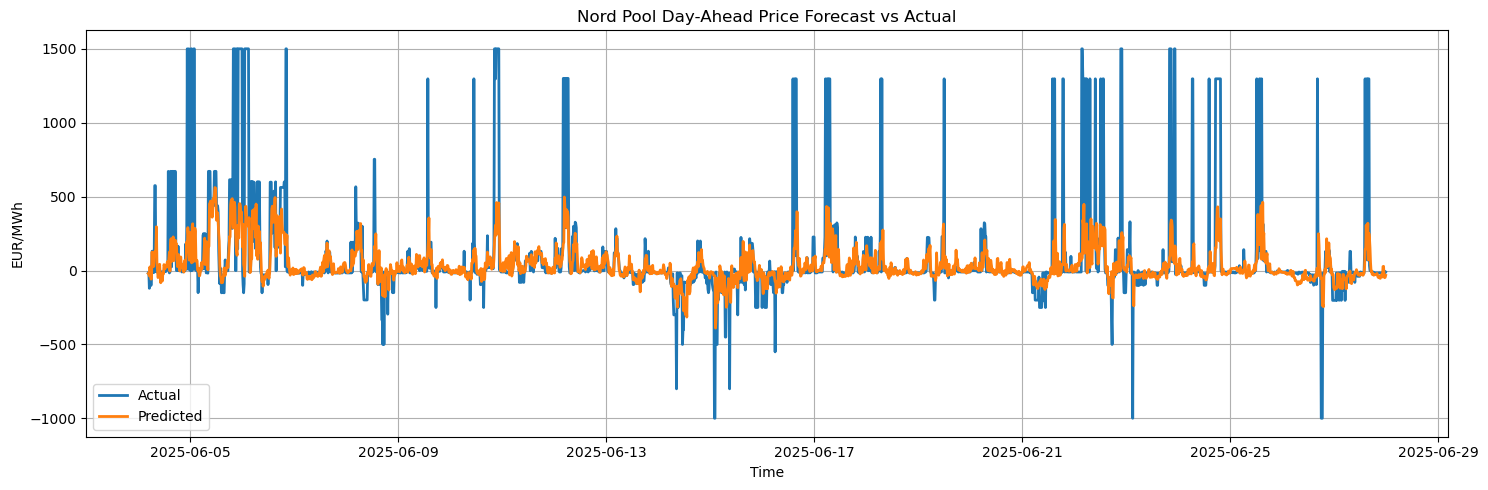

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_xgb, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 features XGBoost:
diffuse_radiation_previous_day1_Klaipeda    0.040554
LV_mfrr_SA_down_activ                       0.038008
EE_mfrr_SA_down_activ                       0.033045
LT_imbalance_price                          0.031141
LV_down_sa_cbmp                             0.029891
LT_dsb                                      0.028721
EE_up_sa_cbmp                               0.025459
LT_mfrr_SA_down_max_bid                     0.024038
LV_up_sa_cbmp                               0.022574
LV_afrr_up_min_bid                          0.022373
dtype: float32


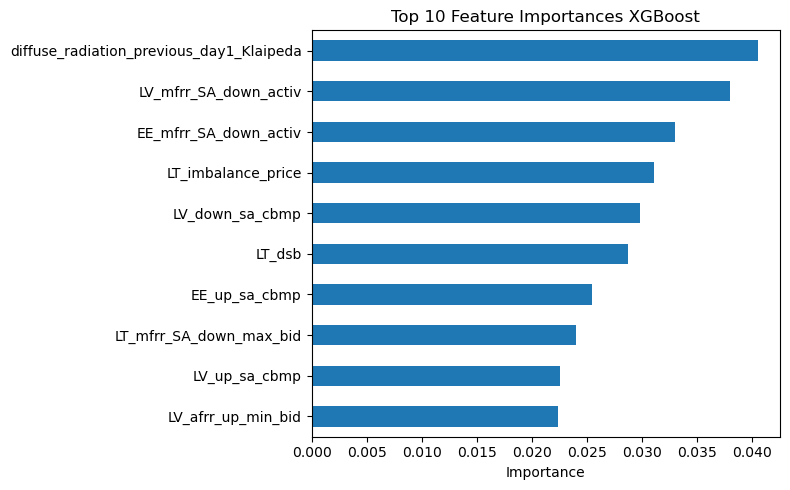

In [16]:
best_model_xgb = grid_search_xgb.best_estimator_

if hasattr(best_model_xgb, "feature_names_in_"):
    feature_names = best_model_xgb.feature_names_in_
else:
    feature_names = X_train.columns

importances_xgb = pd.Series(
    best_model_xgb.feature_importances_, index=feature_names
).sort_values(ascending=False)

print("Top 10 features XGBoost:")
print(importances_xgb.head(10))

importances_xgb.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances XGBoost"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [17]:
model_lgbm = LGBMRegressor(
    random_state=9,
    n_jobs=-1
)

param_grid_lgbm = {
    "n_estimators": [300, 400, 450, 500, 600, 700],
    "max_depth": [5, 6, 7],
    "learning_rate": [0.01, 0.025, 0.05],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
}


grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_lgbm.fit(X_train, y_train)

print("Best parameters (LGBM):", grid_search_lgbm.best_params_)
print("Best MAE CV (LGBM):", -grid_search_lgbm.best_score_)

y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
mae_test_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print("Test MAE (LGBM):", round(mae_test_lgbm, 4))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38850
[LightGBM] [Info] Number of data points in the train set: 9139, number of used features: 210
[LightGBM] [Info] Start training from score 48.895829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

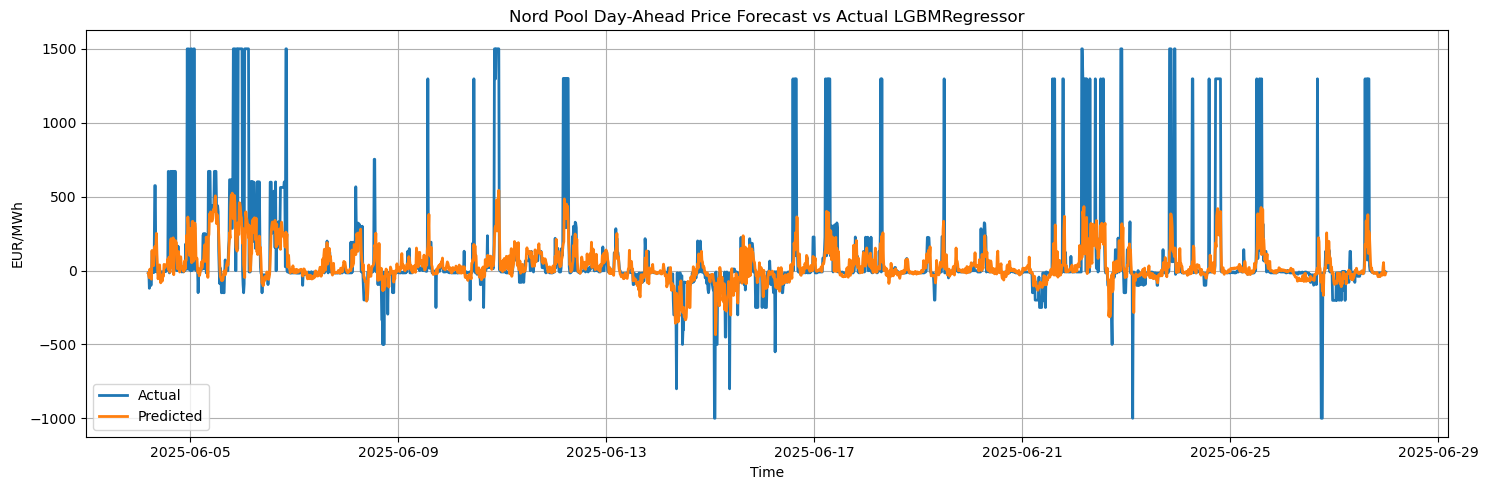

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_lgbm, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual LGBMRegressor")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 features LightGBM:
LT_imb_MW              301
EE_imb_MW              273
LV_imb_MW              227
EE_imbalance_price     224
LV_up_sa_cbmp          207
EE_up_sa_cbmp          204
LT_imbalance_price     181
LV_imbalance_price     162
EE_mfrr_SA_up_vol      160
LT_mfrr_SA_down_vol    152
dtype: int32


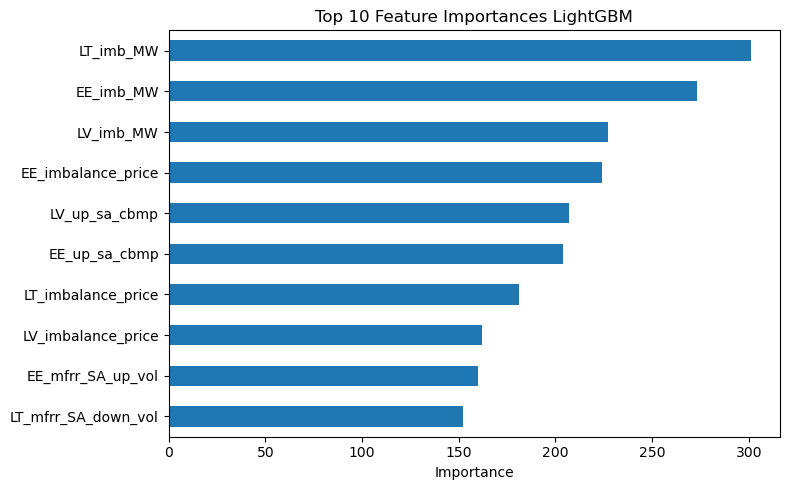

In [19]:
best_model_lgb = grid_search_lgbm.best_estimator_

if hasattr(best_model_lgb, "feature_names_in_"):
    feature_names = best_model_lgb.feature_names_in_
else:
    feature_names = X_train.columns

importances_lgb = pd.Series(
    best_model_lgb.feature_importances_, index=feature_names
).sort_values(ascending=False)

print("Top 10 features LightGBM:")
print(importances_lgb.head(10))

importances_lgb.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances LightGBM"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
model_cat = CatBoostRegressor(
    random_state=9,
    silent=True,
    thread_count=-1
)

param_grid_cat = {
    "iterations": [500, 600, 800, 1000],
    "depth": [3, 4, 5],
    "learning_rate": [0.025, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9,],
    "colsample_bylevel": [0.4, 0.5, 0.6],
}

grid_search_cat = GridSearchCV(
    estimator=model_cat,
    param_grid=param_grid_cat,
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_cat.fit(X_train, y_train, **{"cat_features": ["time_of_day", "season"]})

print("Best parameters (CatBoost):", grid_search_cat.best_params_)
print("Best MAE CV (CatBoost):", -grid_search_cat.best_score_)

y_pred_cat = grid_search_cat.best_estimator_.predict(X_test)
mae_test_cat = mean_absolute_error(y_test, y_pred_cat)

print("Test MAE (CatBoost):", round(mae_test_cat, 4))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_cat, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual CatBoostRegressor")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_model_cat = grid_search_cat.best_estimator_

feature_names = X_train.columns

importances_cat = pd.Series(
    best_model_cat.get_feature_importance(), index=feature_names
).sort_values(ascending=False)

print("Top 10 features CatBoost:")
print(importances_cat.head(10))

importances_cat.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances CatBoost"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()